## M/G/1 Queues

We start with a single-server queue with a FIFO queuing discipline. There is only one server for the queue. When a customer arrives at the queue, he will find himself at the end of the queue, where he will wait until he gets to the front of the queue. He will enter service as soon as the server finishes with the previous customer. Then the customer will get served for some time and then leave the system. We use simulus to simulate this scenario.

Before we start this section, let's first run the following so that we can set up the environment and import the necessary packages.

In [1]:
# for random distributions, random number generators, statistics
import random
import numpy as np
import scipy.stats as stats

# for simulation
import simulus

# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# for animation inside the notebook
import ipywidgets as widgets
from ipywidgets import interact

You should have finished the previous section on pseudo-random number generation for simulation. We pick up from there and first create a generator function to get the random numbers from an exponential distribution with a given mean. The random sequence will start with a given random seed.

In [2]:
def exp_generator(mean, seed):
    rv = stats.expon(scale=mean)
    rv.random_state = np.random.RandomState(seed)
    while True:
        # 100 random numbers as a batch
        for x in rv.rvs(100):
            yield x

### Event-Driven Approach

Let's start with the easy way, by using the event-driven approach, where we handle the customer arrival and departure events, since these are the only instances when the state the queue may change.

When a customer arrives at the queue, two things happen. One is that we need to schedule the arrival of the next customer. The other is that we check whether the customer can be served immediately (that is, the customer is the only one in the system upon arrival). If so, we need to schedule the departure of this customer. 

In simulus, to schedule an event in the future, we use the simulator's `sched()`, which takes the name of a function (which we call the event handler), followed by the list of arguments to be passed to the event handler (we have none for this example). The 'offset' argument is a keyword argument for the `sched()` function (not for the event handler); it specifies the relative time from now the event is scheduled to happen.

The event handler for customer arrival is listed below:

In [3]:
def arrive():
    global num_in_system
    print('%g: customer arrives (num_in_system=%d->%d)' %
          (sim.now, num_in_system, num_in_system+1))
    
    # increment the total number of customers in system
    num_in_system += 1
    
    # schedule next customer's arrival
    sim.sched(arrive, offset=next(inter_arrival_time))
    
    # the arrived customer is the only one in system
    if num_in_system == 1:
        # schedule the customer's departure
        sim.sched(depart, offset=next(service_time))

When a customer gets served, he leaves the system. After that, if there are other customers waiting, the next customer will be served immediately. For that, we need to schedule the departure of that customer. 

The event handler for customer departure is listed below:

In [4]:
def depart():
    global num_in_system
    print('%g: customer departs (num_in_system=%d->%d)' %
          (sim.now, num_in_system, num_in_system-1))
    
    # decrement the total number of customers in system
    num_in_system -= 1
    
    # there are remaining customers in system
    if num_in_system > 0:
        # schedule the next customer's departure
        sim.sched(depart, offset=next(service_time))

Now we are ready to simulate the queue. We instantiate a simulator. We then create two generators, one for the inter-arrival time and the other for the service time. The two generators use separate random streams, seeded from the simulator-specific random sequence. Before we start the simulation, we schedule the first customer's arrival. And finally we run the simulation for 10 simulated seconds.

In [5]:
random.seed(13579) # global random seed

sim = simulus.simulator('ssq')
inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
service_time = exp_generator(0.8, sim.rng().randrange(2**32))

num_in_system = 0
sim.sched(arrive, offset=next(inter_arrival_time))
sim.run(10)

0.0317216: customer arrives (num_in_system=0->1)
0.171341: customer departs (num_in_system=1->0)
0.450915: customer arrives (num_in_system=0->1)
1.13174: customer departs (num_in_system=1->0)
2.76384: customer arrives (num_in_system=0->1)
3.74348: customer departs (num_in_system=1->0)
4.53929: customer arrives (num_in_system=0->1)
4.58801: customer departs (num_in_system=1->0)
5.84336: customer arrives (num_in_system=0->1)
6.15646: customer departs (num_in_system=1->0)
6.64925: customer arrives (num_in_system=0->1)
6.76268: customer departs (num_in_system=1->0)
8.03519: customer arrives (num_in_system=0->1)
8.08347: customer arrives (num_in_system=1->2)
8.12795: customer arrives (num_in_system=2->3)
8.26366: customer arrives (num_in_system=3->4)
8.40052: customer departs (num_in_system=4->3)
8.68481: customer departs (num_in_system=3->2)


The output from simulation is kind of boring. Let's gather some statistics and try to plot them. 

We want to collect the wait time of the customers. To do that, we need to remember the time when the customer arrives at the system and also the time when the customer departs from the system. There are many ways to do the bookkeeping, the easy way we found is to simply use a data structure to keep track of the waiting customers. We use a deque (double-ended queue). We insert the time at which a customer enters the system and remove a time when the customer leaves. The time in-between is the customers wait time (including both queuing time and time in service). 

We also want to track the number of customers in the system as it changes over time. For this, we use a list and each entry in the list is a tuple consisted of the time and the number of customers enqueued at the time.

The event handlers revised with bookkeeping are listed below:

In [6]:
from collections import deque

def arrive():
    # add the customer to the end of the queue
    queue.append(sim.now)
    in_systems.append((sim.now, len(queue)))
    
    # schedule next customer's arrival
    sim.sched(arrive, offset=next(inter_arrival_time))
    
    # the arrived customer is the only one in system
    if len(queue) == 1:
        # schedule the customer's departure
        sim.sched(depart, offset=next(service_time))
        
def depart():
    # remove a customer from the head of the queue
    t = queue.popleft()
    in_systems.append((sim.now, len(queue)))
    waits.append(sim.now-t)
    
    # there are remaining customers in system
    if len(queue) > 0:
        # schedule the next customer's departure
        sim.sched(depart, offset=next(service_time))

Now we can run the simulation to gather the statistics. We can calculate the sample mean and standard deviation of the wait time. We can also calculate the average number of customers in the system. 

In [7]:
queue = deque()
in_systems = [(0,0)]
waits = []

sim = simulus.simulator('ssq')
inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
service_time = exp_generator(0.8, sim.rng().randrange(2**32))
sim.sched(arrive, offset=next(inter_arrival_time))
sim.run(10000)

print('wait times: %r...' % waits[:3])
print('number customers in systems: %r...' % in_systems[:3])

waits = np.array(waits)
print("wait time: mean=%g, stdev=%g" % 
      (waits.mean(), waits.std()))

# area under curve divided by time is the 
# average number of customers in system
auc, last_t, last_l = 0, 0, 0
for t, l in in_systems:
    auc += (t-last_t)*last_l
    last_t, last_l = t, l
print("avg number of customers in system = %g" % (auc/last_t))

wait times: [0.1396196817329908, 0.6808302178418295, 0.9796324169967114]...
number customers in systems: [(0, 0), (0.031721620996692464, 1), (0.17134130272968326, 0)]...
wait time: mean=2.59974, stdev=2.71376
avg number of customers in system = 2.18839


The queuing theory for M/M/1 queue tells us that in steady state, the mean wait time should be $1/(\mu - \lambda)$ and the mean number of customers in system should be $\lambda/(\mu - \lambda)$. That is, $\lambda=1/1.2=5/6$ and $\mu=1/0.8=5/4$. Therefore, the mean wait time should be 2.4, and the mean number of customers in system should be 2.0. We can use long-run simulation to obtain better steady-state estimations. But in most simulation cases, we'd be more interested in the transient behaviors of the system under study.  

The data collected during simulation can also be used to generate many interesting plots. For example, we can plot the number of customers in the system as it changes over time. In the following, we only plot the first few.

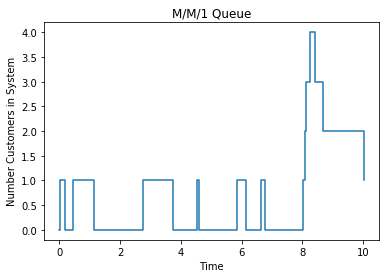

In [8]:
plt.step(*zip(*in_systems[:20]), where='post')
plt.title("M/M/1 Queue")
plt.xlabel("Time")
plt.ylabel("Number Customers in System")
plt.show()

We can plot histogram of the wait time. And we can examine the percentage of customers who have experienced long wait time, say, more than 10 seconds. 

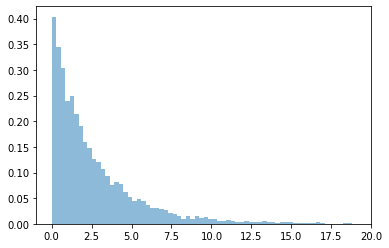

2.61376% customers experienced wait time more than 10 seconds,
while 90% of customers experienced wait time no more than 6.06863 seconds


In [9]:
plt.hist(waits, alpha=0.5, bins='auto', density=True)
plt.show()
print('%g%% customers experienced wait time more than 10 seconds,' % 
      (100*(waits>10).sum()/len(waits)))
print('while 90%% of customers experienced wait time no more than %g seconds' % 
      np.percentile(waits, 90))

### Process-Oriented Approach

The event-driven approach is more than sufficient to handle the single-server queue with the FIFO queuing discipline. However, the situation may get more complicated using the event-driven approach, when we deal with multiple servers with multiple queues and with more complicated queuing disciplines (such as priority-based scheduling with preemption). A strong aspect of simulus that distinguishes simulus from most other simulators is its natural support for process-oriented simulation. Simulus provides high-level modeling abstractions (such as traps, semaphores, resources, stores, and mailboxes) in order for users to create more intuitive and expressive simulation models using the process-oriented approach. We start here with the single-server queue and later we will expand it for more complicated queuing scenarios.

Rather than directly scheduling events (one still can, if needs to), one create processes and have the processes to run their own course. Each process is a single thread of control. A process can be suspended, sleeping for time or waiting for resources. A process can resume execution, after sleep or when the wait conditions have been satisfied.

For the single-server queue, we use a process to generate the customers. A process starts from a normal function, in this case, `gen_arrivals()`. Within the function, the process enters a forever loop, in which the process sleeps for some time (which is a random value returned from the `inter_arrival_time` generator function), and then creates another process that starts from a function called customer. As its name suggests, the process represents a customer who arrives at the queue. 

In [10]:
def gen_arrivals():
    while True:
        sim.sleep(next(inter_arrival_time))
        sim.process(customer)

The customer process waits for a server to be available. A server in this case is implemented as a resource. A process trying to acquire a resource may be suspended if the resource is unavailable (i.e., if it has been already acquired by another customer). In that case, the process will be put in a queue (with unlimited space) maintained by the resource. 

Once the server becomes available, one of the waiting processes will be selected. By default, the resource is FIFO: it selects the waiting process who has entered the queue first. When the selected process acquires the server, it sleeps for some time representing the customer being served. The sleep time is a random value returned from the `service_time` generator function. After the sleep, the process releases the server so that if other customer processes are waiting for the server, the server will select the next customer in queue.

In [11]:
def customer():
    print('%g: customer arrives (num_in_system=%d->%d)' %
          (sim.now, server.num_in_system(), server.num_in_system()+1))
    server.acquire()
    sim.sleep(next(service_time))
    print('%g: customer departs (num_in_system=%d->%d)' %
          (sim.now, server.num_in_system(), server.num_in_system()-1))
    server.release()

Now we are ready to simulate the queue. Like before, we instantiate a simulator and then create the two generators for the inter-arrival time and for the service time. We create the server as a resource and then starts the gen_arrivals process. Finally we run the simulation for 10 simulated seconds. The results should be the same as those from the event-driven approach.

In [12]:
sim = simulus.simulator('ssq')
inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
service_time = exp_generator(0.8, sim.rng().randrange(2**32))
server = sim.resource()
sim.process(gen_arrivals)
sim.run(10)

0.0317216: customer arrives (num_in_system=0->1)
0.171341: customer departs (num_in_system=1->0)
0.450915: customer arrives (num_in_system=0->1)
1.13174: customer departs (num_in_system=1->0)
2.76384: customer arrives (num_in_system=0->1)
3.74348: customer departs (num_in_system=1->0)
4.53929: customer arrives (num_in_system=0->1)
4.58801: customer departs (num_in_system=1->0)
5.84336: customer arrives (num_in_system=0->1)
6.15646: customer departs (num_in_system=1->0)
6.64925: customer arrives (num_in_system=0->1)
6.76268: customer departs (num_in_system=1->0)
8.03519: customer arrives (num_in_system=0->1)
8.08347: customer arrives (num_in_system=1->2)
8.12795: customer arrives (num_in_system=2->3)
8.26366: customer arrives (num_in_system=3->4)
8.40052: customer departs (num_in_system=4->3)
8.68481: customer departs (num_in_system=3->2)


### The Effect of Service Time Distribution

Let's change the service time distribution from exponential to a truncated normal distribution, which specifies a particular range between a and b. We create another generator function for this:

In [13]:
def truncnorm_generator(a, b, seed):
    rv = stats.truncnorm(a, b)
    rv.random_state = np.random.RandomState(seed)
    while True:
        # 100 random numbers as a batch
        for x in rv.rvs(100):
            yield x

We are going to run the simulation and show the effect of the service time distribution on the customer's wait time *on the fly*. To do this, we disable the print-outs in the original customer() method.

In [14]:
def gen_arrivals():
    while True:
        sim.sleep(next(inter_arrival_time))
        sim.process(customer)
        
def customer():
    server.acquire()
    sim.sleep(next(service_time))
    server.release()

We are wrapping around each simulation run using a function called `sim_run()`. In this case, we can simply call this function to have one run of the simulation and return the results. Since in our example both `gen_arrivals()` and `customer()` use module global variables: 'sim', 'inter_arrival_time', 'service_time', and 'server'. We need to make them global from the `sim_run()` function. 

To gather the statistics, we use DataCollector provided by simulus. When creating the DataCollector instance, we specify the kind of data to be gathered at the resource. In this example, we would like to keep all the data series for `system_times`, which is just another name for the wait time of all the customers using the resource. When we create the resource, we attach the DataCollector instance. After the simulation run, we retrieve the collected data from the DataCollector instance and return them from the function.

In [15]:
def sim_run(a, b):
    global sim, inter_arrival_time, service_time, server
    sim = simulus.simulator('mg1')
    inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm_generator(a, b, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries(all)')
    server = sim.resource(collect=dc)
    sim.process(gen_arrivals)
    sim.run(1000)
    return dc.system_times.data()

Now we are all set for interactive plotting. We fix 'a' and use a slider to choose 'b'. The `plot_hist()` function calls `sim_run()` to get the wait time of all customers in a list and we plot the histogram accordingly.

In [16]:
def plot_hist(a, b):
    waits = sim_run(a, b)
    plt.hist(waits, alpha=0.5, bins='auto', density=True)
    plt.xlim(0, 8)
    plt.show()
interact(plot_hist, a=widgets.fixed(0), b=(0.1, 2.0, 0.1))
None

interactive(children=(FloatSlider(value=1.0, description='b', max=2.0, min=0.1), Output()), _dom_classes=('wid…

The wait time shown in the histogram is from one run of the simulation. To be statistically meaningful, we need to run many trials of each simulation setting and show the results with confidence intervals.

In the following example, we revise the `sim_run()` function to just collect the summary statistics for wait time and return the mean value (which would consume far less time and memory). This is achieved by configuring the DataCollector with the argument 'system_times' set to be 'dataseries' rather than 'dataseries(all)'.

We run the simulation for 25 times at each parameter setting. It is important to note that there's a subtle difference from the previous when we create the simulator for each simulation run. Now the simulator is nameless! This is important, because otherwise the simulator will generate the same random sequence regardless of how many times we run the simulation. Without a name, the simulator will be created with a randomly generated name (using the default random number generator in Python's `random` module). Recall that the simulator's attached random number generator is seeded from the namespace (which we do not change since we use the same global random seed) and the simulator's name. In this case, the simulator would create a different random sequence, which is exactly what we'd need. 

In [17]:
def sim_run(a, b):
    global sim, inter_arrival_time, service_time, server
    sim = simulus.simulator()
    inter_arrival_time = exp_generator(1.2, sim.rng().randrange(2**32))
    service_time = truncnorm_generator(a, b, sim.rng().randrange(2**32))
    dc = simulus.DataCollector(system_times='dataseries')
    server = sim.resource(collect=dc)
    sim.process(gen_arrivals)
    sim.run(1000)
    return dc.system_times.mean()

The following code will run pretty slow. Be prepared! We are conducting 30*25=750 simulation runs before we can get the plot. 

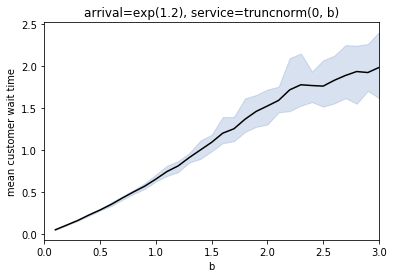

In [18]:
x = np.linspace(0.1, 3.0, 30)
y = []
e1 = []
e2 = []
for b in x:
    z = []
    for _ in range(25):
        z.append(sim_run(0, b))
    z = np.array(z)
    y.append(z.mean())
    e1.append(np.percentile(z, 5))
    e2.append(np.percentile(z, 95))

plt.plot(x, y, 'k-')
plt.xlim(0, 3.0)
plt.title('arrival=exp(1.2), service=truncnorm(0, b)')
plt.ylabel('mean customer wait time')
plt.xlabel('b')
plt.fill_between(x, e1, e2, color='#386cb0', alpha=0.2)
plt.show()

The above plot shows that the mean wait time increases as we increase 'b', which increases both the mean and the standard deviation of the service time. The confidence interval also seems to be getting larger as we increase 'b'. 

As 'b' increases, the service rate decreases and the difference between the arrival rate and service rate decreases as a result. It takes longer for the simulation to reach steady state. We fixed each simulation run to last for 1000 simulated seconds, which may not be sufficient for a larger 'b'.